In [1]:
from npDoseResponse import DerivEffect, IntegEst, DerivEffectBoot, IntegEstBoot, RegAdjust
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

## Example 2: Nonlinear Effect Model

We generate independent and identically distributed (i.i.d.) data $\left\{(Y_i,T_i,S_i)\right\}_{i=1}^n \subset \mathbb{R}^3$ with $n=300$ from the following nonlinear effect model as:
$$Y=T^2+T+10Z+\epsilon, \quad T=\cos\left(\pi Z^3\right) + \frac{Z}{4} + E, \quad Z=4S_1+S_2, \quad \text{ and } \quad \mathbf{S}_i=(S_{i,1},S_{i,2}),$$
where $S_{i,1},S_{i,2} \sim_{i.i.d.} \text{Uniform}[-1,1]$, $E\sim \text{Uniform}[-0.1, 0.1]$ is an independent treatment variation, and $\epsilon \sim \mathcal{N}(0,1)$ is an exogenous normally distributed noise. The true dose-response curve is $m(t)=t^2+t$, and the true derivative effect is $\theta(t)=m'(t)=2t+1$.

In [2]:
n = 300

# Generate a random sample from the nonlinear effect model
np.random.seed(123)
S = np.concatenate([2*np.random.rand(n).reshape(-1,1) - 1, 
                    2*np.random.rand(n).reshape(-1,1) - 1], axis=1)
Z = 4*S[:,0] + S[:,1]
E = 0.2*np.random.rand(n) - 0.1
T = np.cos(np.pi*Z**3) + Z/4 + E
Y = T**2 + T + 10*Z + np.random.normal(loc=0, scale=1, size=n)
X = np.concatenate([T.reshape(-1,1), S], axis=1)

In [3]:
t_qry = np.linspace(min(T)+0.01, max(T)-0.01, 100)

# Traditional regression adjustment estimators
Y_RA = RegAdjust(Y, X, t_eval=t_qry, degree=2, deriv_ord=0, h=None, b=None, C_h=6, C_b=3,
                 print_bw=False, kernT="epanechnikov", kernS="epanechnikov", parallel=True, processes=14)
Y_RA_deriv = RegAdjust(Y, X, t_eval=t_qry, degree=2, deriv_ord=1, h=None, b=None, C_h=6, C_b=3,
                        print_bw=False, kernT="epanechnikov", kernS="epanechnikov", parallel=True, processes=14)

In [4]:
# Propose integral and localized derivative estimators
theta_est = DerivEffect(Y, X, t_eval=t_qry, h_bar=None, kernT_bar="gaussian", h=None, b=None, C_h=6, C_b=3,
                         print_bw=False, degree=2, deriv_ord=1, kernT="epanechnikov", kernS="epanechnikov",
                         parallel=True, processes=14)

m_est = IntegEst(Y, X, t_eval=t_qry, h_bar=None, kernT_bar="gaussian", h=None, b=None, C_h=6, C_b=3,
                  print_bw=False, degree=2, deriv_ord=1, kernT="epanechnikov", kernS="epanechnikov", 
                  parallel=True, processes=14)

In [5]:
# Nonparametric bootstrap inference
np.random.seed(123)
theta_est, theta_est_boot, theta_alpha, theta_alpha_var = DerivEffectBoot(Y, X, t_eval=t_qry, h_bar=None, 
                                                                          kernT_bar="gaussian", h=None, b=None, 
                                                                          C_h=6, C_b=3, print_bw=False, 
                                                                          degree=2, deriv_ord=1, 
                                                                          kernT="epanechnikov", kernS="epanechnikov", 
                                                                          boot_num=500, parallel=True, processes=14)

m_est, m_est_boot, m_alpha, m_alpha_var = IntegEstBoot(Y, X, t_eval=t_qry, h_bar=None, kernT_bar="gaussian", 
                                                       h=None, b=None, C_h=6, C_b=3, print_bw=False, 
                                                       degree=2, deriv_ord=1, kernT="epanechnikov", kernS="epanechnikov", 
                                                       boot_num=500, parallel=True, processes=14)

In [6]:
# Compute the 95% uniform confidence bands
# theta_boot_sup = np.max(np.abs(theta_est_boot - theta_est), axis=1)
# m_boot_sup = np.max(np.abs(m_est_boot - m_est), axis=1)

# theta_alpha = np.quantile(theta_boot_sup, 0.95)
# m_alpha = np.quantile(m_boot_sup, 0.95)

# # Compute the 95% pointwise confidence intervals
# theta_boot_abs = np.abs(theta_est_boot - theta_est)
# m_boot_abs = np.abs(m_est_boot - m_est)

# theta_alpha_var = np.quantile(theta_boot_abs, 0.95, axis=0)
# m_alpha_var = np.quantile(m_boot_abs, 0.95, axis=0)

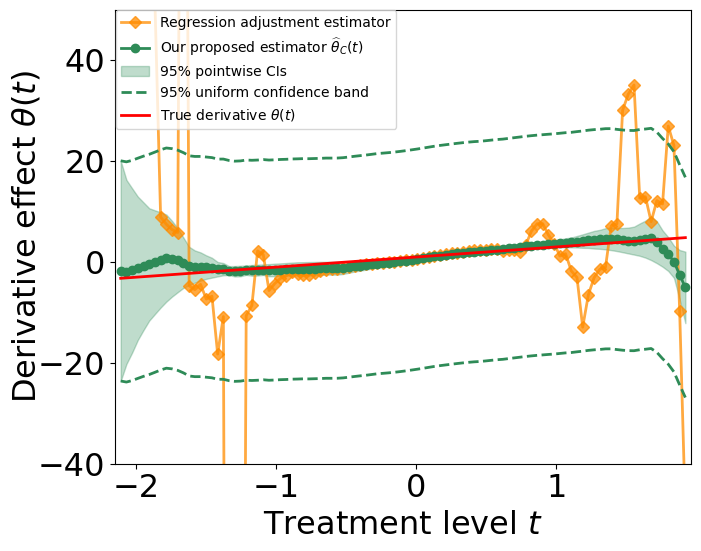

In [6]:
plt.rcParams.update({'font.size': 23})
plt.figure(figsize=(7.5, 6))
plt.plot(t_qry, Y_RA_deriv, color='darkorange', marker='D', linewidth=2, alpha=0.75, 
         label=r'Regression adjustment estimator')
plt.plot(t_qry, theta_est, color='seagreen', marker='o', linewidth=2, 
         label=r'Our proposed estimator $\widehat{\theta}_C(t)$')
plt.fill_between(t_qry, theta_est - theta_alpha_var, theta_est + theta_alpha_var, color='seagreen', 
                 alpha=.3, label='95% pointwise CIs')
plt.plot(t_qry, theta_est - theta_alpha, linestyle='dashed', color='seagreen', linewidth=2)
plt.plot(t_qry, theta_est + theta_alpha, linestyle='dashed', color='seagreen', linewidth=2,
         label='95% uniform confidence band')
plt.plot(t_qry, 2*t_qry+1, color='red', linewidth=2, label=r'True derivative $\theta(t)$')
plt.ylim([-40,50])
plt.legend(fontsize=10, loc='upper left', bbox_to_anchor=(-0.011, 1.015))
plt.xlabel('Treatment level $t$')
plt.ylabel(r'Derivative effect $\theta(t)$', labelpad=-3)
plt.margins(x=0.01, y=0.01)
plt.tight_layout()
plt.show()

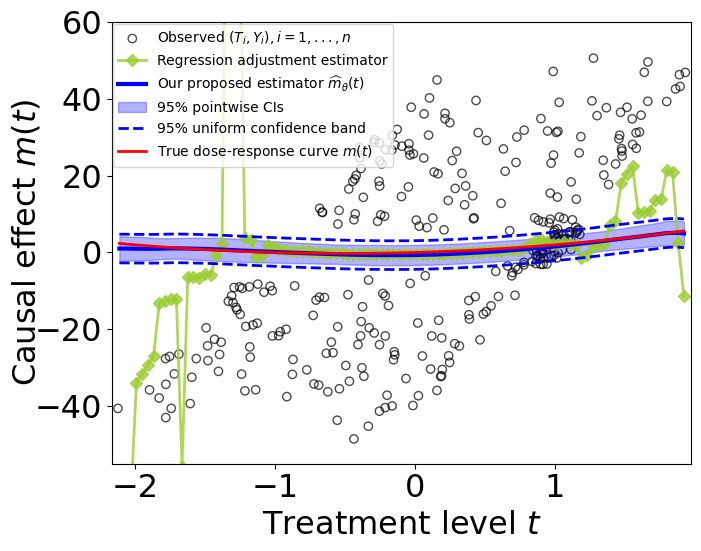

In [7]:
plt.rcParams.update({'font.size': 23})
plt.figure(figsize=(7.5,6))
plt.scatter(T, Y, facecolors='none', edgecolors='black', alpha=0.7, 
            label=r'Observed $(T_i,Y_i), i=1,...,n$')
# sns.rugplot(T, height=0.025, color='grey')
plt.plot(t_qry, Y_RA, color='yellowgreen', marker="D", linewidth=2, alpha=0.8, 
         label=r'Regression adjustment estimator')
plt.plot(t_qry, m_est, color='blue', linewidth=3, label=r'Our proposed estimator $\widehat{m}_{\theta}(t)$')
plt.fill_between(t_qry, m_est - m_alpha_var, m_est + m_alpha_var, color='b', 
                 alpha=.3, label='95% pointwise CIs')
plt.plot(t_qry, m_est - m_alpha, linestyle='dashed', color='blue', linewidth=2)
plt.plot(t_qry, m_est + m_alpha, linestyle='dashed', color='blue', linewidth=2,
         label='95% uniform confidence band')
plt.plot(t_qry, t_qry**2 + t_qry, color='red', linewidth=2, label=r'True dose-response curve $m(t)$')
plt.legend(fontsize=10, loc='upper left', bbox_to_anchor=(-0.011, 1.012))
plt.ylim([-55, 60])
plt.xlabel('Treatment level $t$')
plt.ylabel(r'Causal effect $m(t)$', labelpad=-5)
plt.margins(x=0.01, y=0.02)
plt.tight_layout()
plt.show()